# Timing duration and the transient effects of artificial propogation 

Most of the theoretical work on describing the effect of artificial propogation on the fittness of natrual populaitons has focused on the long run or steady state outcomes of these programs. this is a very reasonable aproach for many application where propogatin is expected to be continued indefinitly (e.g. aquaculture, sumplimentation for harvest). However, when artificial propogation is used for conservation purposes it is often viewed as an emergency stop gap measure designed to have a limited duration, thus it is critical to understand the short run or transtent effects of these programs. Furthermore, the transient dynamics can be important for identifying the potential longrun effect of more perment stocking opperations with monitoring and evaluation programs. 

In this module I will use simulation to test the effect of releasing maladapted individuals into a population. I will show the long run effects of these action if the program was maintained indefinitly and compare them to a case where stocking occurs for a limited period of time. I will also consider three other important factors the degree of maladaption among the propogated individuals, the strength of selection and the productivity of the natrual population.

The model I will simulate from is an age structured model that describes the genetic differnces between natrual and propogated individuals with the Slatkin (1970) model of a quantitative genetic character. The age sturctured popualtion dynamics will be parameterized to represent white sturgeon popualtion in the Fraser river british columbia using data from previous stock assessment. 

## Initialize the model

In [55]:
include("AgeStructuredModels.jl")
include("DemographicParameters.jl")
include("AgeTraitStructuredModels.jl")
using Plots
theme(:solarized)

# initialize demographic model - paramters loaded from DemographicParameters.jl 
# see tests in "TestDemographicParametersparams.ipynb"
mod = AgeStructuredModels.init(150,DemographicParameters.Smyth_2016_sr,DemographicParameters.Smyth_2016_survival,
    DemographicParameters.Smyth_16_F_vec)

Rstar = AgeStructuredModels.compute_Rstar(mod)

# set base genetic paramters
Vle = 1.0
θ = 0.0
s = 0.1
min = -5
max = 20 
Δz = 0.15

# set base paramters for propogated individuals 
μ_im = 5.0
R_im = 0.5 * Rstar  # 50% natrual recrutment 

# initialize coupled genetic-demogrpahic model 
pop = AgeTraitStructuredModels.init(mod,Vle, θ, s, min, max, Δz)
im = AgeTraitStructuredModels.init_imigrants(pop, R_im, μ_im)
print(" ")

## Set discrete time populaiton dynamics  

Order of events: reproduction , density dependence, selection, immigration,  aging

# Time series 

## s = 0.1

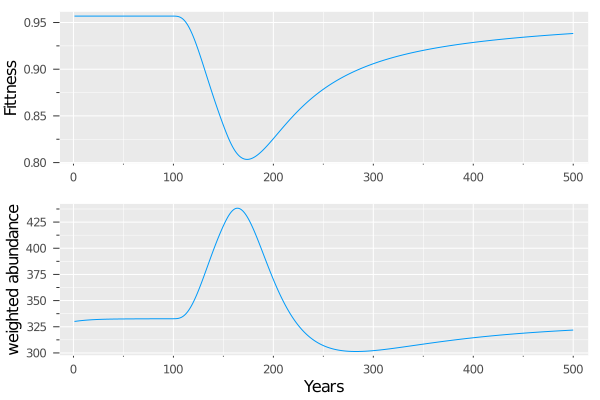

In [59]:
theme(:ggplot2)
AgeTraitStructuredModels.reset!(pop,0.1)
T = 500
t_stock = 100
T_stock = 150
fittness = zeros(T)
recruitment = zeros(T)
SSB = zeros(T)
for t in 1:T
    if t < t_stock
        AgeTraitStructuredModels.time_step_DSI!(pop)
        recruitment[t] = AgeTraitStructuredModels.recruitment(pop)
    elseif t < T_stock
        AgeTraitStructuredModels.time_step_DSI!(pop,im)
        recruitment[t] = AgeTraitStructuredModels.recruitment(pop) - im.N
    else
        AgeTraitStructuredModels.time_step_DSI!(pop)
        recruitment[t] = AgeTraitStructuredModels.recruitment(pop)
    end 
    fittness[t] = AgeTraitStructuredModels.fittness(pop)
    
    SSB[t] = AgeTraitStructuredModels.spawning_stock(pop)
end 
p1 = Plots.plot(fittness, ylab = "Fittness", label = "")
#p2 = Plots.plot(recruitment, ylab = "Recruits")
p3 = Plots.plot(SSB, ylab = "weighted abundance", xlab = "Years", label = "")
plot(p1,p3, layout = (2,1))

## s = 0.2

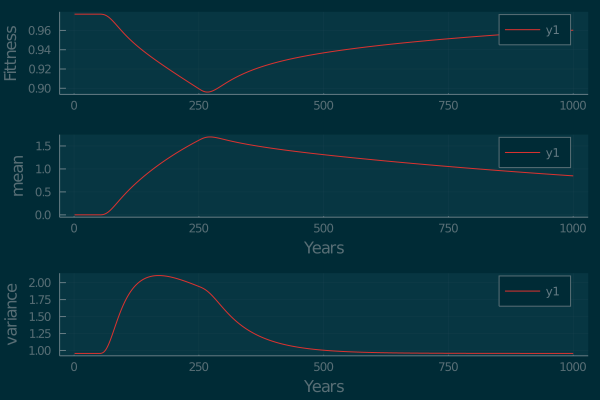

In [43]:
# set base paramters for propogated individuals 
μ_im = 4.0
R_im = 0.2 * Rstar  # 50% natrual recrutment 

# initialize coupled genetic-demogrpahic model 
pop = AgeTraitStructuredModels.init(mod,Vle, θ, s, min, max, Δz)
im = AgeTraitStructuredModels.init_imigrants(pop, R_im, μ_im)

AgeTraitStructuredModels.reset!(pop,0.05)
T = 1000
t_stock = 50
T_stock = 250
fittness = zeros(T)
recruitment = zeros(T)
SSB = zeros(T)
mu, sigma = zeros(T), zeros(T)
for t in 1:T
    if t < t_stock
        AgeTraitStructuredModels.time_step_DSI!(pop)
        recruitment[t] = AgeTraitStructuredModels.recruitment(pop)
    elseif t < T_stock
        AgeTraitStructuredModels.time_step_DSI!(pop,im)
        recruitment[t] = AgeTraitStructuredModels.recruitment(pop) - im.N
    else
        AgeTraitStructuredModels.time_step_DSI!(pop)
        recruitment[t] = AgeTraitStructuredModels.recruitment(pop)
    end 
    fittness[t] = AgeTraitStructuredModels.fittness(pop)
    SSB[t] = AgeTraitStructuredModels.spawning_stock(pop)
    mu[t], sigma[t] = AgeTraitStructuredModels.trait_moments_born(pop)
end 
p1 = Plots.plot(fittness, ylab = "Fittness")
p2 = Plots.plot(recruitment, ylab = "Recruits")
p3 = Plots.plot(SSB, ylab = "SSB", xlab = "Years")
p4 = Plots.plot(mu, ylab = "mean", xlab = "Years")
p5 = Plots.plot(sigma.^2, ylab = "variance", xlab = "Years")
plot(p1,p4,p5, layout = (3,1))

# Long run outcomes 

In [61]:

function equilibrium(population, immigrants, s, prop_im, μ_im)
    AgeTraitStructuredModels.reset!(population,0.2)
    Rstar = AgeStructuredModels.compute_Rstar(population.ageStructure)
    AgeTraitStructuredModels.reset_immigrants!(immigrants,population, prop_im*Rstar, μ_im)
    W0 = 10
    W1 = AgeTraitStructuredModels.spawning_stock(population)
    iter = 0
    while abs(W0 - W1) > 10^-6.0
        iter += 1
        W0 = W1
        AgeTraitStructuredModels.time_step_DSI!(pop,im)
        W1 = AgeTraitStructuredModels.spawning_stock(population)
    end 

    μrec, σrec = AgeTraitStructuredModels.trait_moments_recruits(population)
    μSSB, σSSB = AgeTraitStructuredModels.trait_moments_spawning(population)
    W = AgeTraitStructuredModels.fittness(population)
    SSB = AgeTraitStructuredModels.spawning_stock(population)
    rec = AgeTraitStructuredModels.recruitment(population)
    
    return W, SSB, rec, μrec, σrec, μSSB, σSSB
end 


function min_outcomes(population, immigrants, T, s, prop_im, μ_im)
    AgeTraitStructuredModels.reset!(population,0.2)
    Rstar = AgeStructuredModels.compute_Rstar(population.ageStructure)
    AgeTraitStructuredModels.reset_immigrants!(immigrants,population, prop_im*Rstar, μ_im)
    W0 = 10
    F0 = 10
    W1 = AgeTraitStructuredModels.spawning_stock(population)
    F1 = AgeTraitStructuredModels.fittness(population)
    iter = 0
    Fmin = -1
    flip = true
    while (W0 > W1) | flip
        iter += 1
        W0 = W1
        F0 = F1
        if iter < T
            AgeTraitStructuredModels.time_step_DSI!(pop,im)
        else
            AgeTraitStructuredModels.time_step_DSI!(pop)
        end
        W1 = AgeTraitStructuredModels.spawning_stock(population)
        F1 = AgeTraitStructuredModels.fittness(population)
        if (F0 < F1) & (Fmin == -1)
            Fmin = F1
        end 
        
        if flip & (W0 > W1)
            flip = false
        end 
        
    end 
   
    return Fmin, W1
end 

min_outcomes (generic function with 1 method)

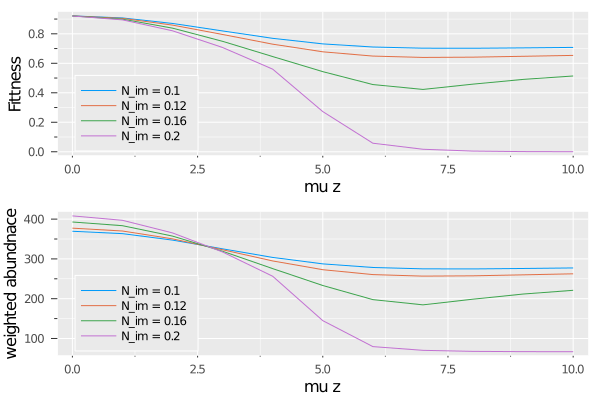

In [63]:

μim = 0.0:1.0:10
s, prop_im = 0.1, 0.1
#equilibrium(pop, im, s, prop_im, 5)
W = broadcast(x -> equilibrium(pop, im, s, prop_im, x)[1:2], μim )
p1 = Plots.plot(μim, broadcast(i -> W[i][1], 1:length(μim )),label = string("N_im = ", prop_im),
                legend =:bottomleft, xlab = "mu z", ylab = "Fittness" )
p2 = Plots.plot(μim, broadcast(i -> W[i][2], 1:length(μim )),label = string("N_im = ", prop_im),
                legend =:bottomleft, xlab = "mu z", ylab = "weighted abundnace" )
for prop_im in 0.12:0.04:0.2
    W = broadcast(x -> equilibrium(pop, im, s, prop_im, x)[1:2], μim )
    Plots.plot!(p1,μim, broadcast(i -> W[i][1], 1:length(μim )),label = string("N_im = ", prop_im) )
    Plots.plot!(p2,μim, broadcast(i -> W[i][2], 1:length(μim )),label = string("N_im = ", prop_im))
end 
plot(p1,p2, layout = (2,1))

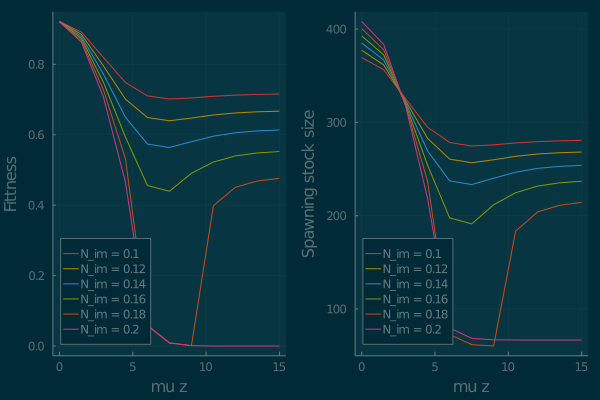

In [49]:
μim = 0.0:1.5:15
s, prop_im = 0.025, 0.1
#equilibrium(pop, im, s, prop_im, 5)
W = broadcast(x -> equilibrium(pop, im, s, prop_im, x)[1:2], μim )
p1 = Plots.plot(μim, broadcast(i -> W[i][1], 1:length(μim )),label = string("N_im = ", prop_im),
                legend =:bottomleft, xlab = "mu z", ylab = "Fittness" )
p2 = Plots.plot(μim, broadcast(i -> W[i][2], 1:length(μim )),label = string("N_im = ", prop_im),
                legend =:bottomleft, xlab = "mu z", ylab = "Spawning stock size" )
for prop_im in 0.12:0.02:0.2
    W = broadcast(x -> equilibrium(pop, im, s, prop_im, x)[1:2], μim )
    Plots.plot!(p1,μim, broadcast(i -> W[i][1], 1:length(μim )),label = string("N_im = ", prop_im) )
    Plots.plot!(p2,μim, broadcast(i -> W[i][2], 1:length(μim )),label = string("N_im = ", prop_im))
end 
plot(p1,p2)

# Plot minimum values for temporary programs

In [65]:
include("DemographicParameters.jl")
DemographicParameters.Smyth_2016_T1

52.77022269607694

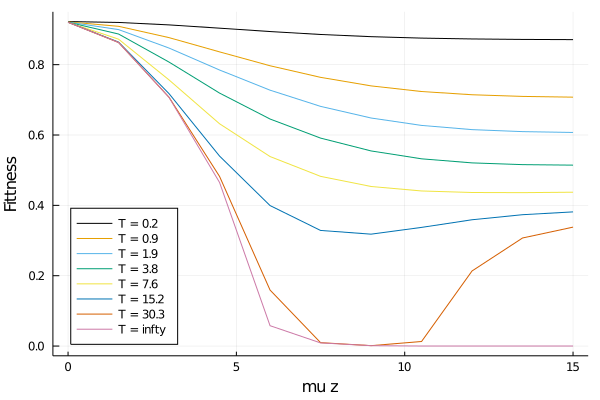

In [80]:
include("AgeTraitStructuredModels.jl")
μim = 0.0:1.5:15
s, prop_im = 0.1, 0.2
T = 10
theme(:wong2)
#equilibrium(pop, im, s, prop_im, 5)
Tg = round(T / DemographicParameters.Smyth_2016_T1, digits = 1)
W = broadcast(x -> min_outcomes(pop, im, T, s, prop_im, x)[1:2], μim )
p1 = Plots.plot(μim, W)
p1 = Plots.plot(μim, broadcast(i -> W[i][1], 1:length(μim )),label = string("T = ", Tg),
                legend =:bottomleft, xlab = "mu z", ylab = "Fittness")
p2 = Plots.plot(μim, broadcast(i -> W[i][2], 1:length(μim )),label = string("T = ", Tg),
                legend =:bottomleft, xlab = "mu z", ylab = "weighted abundance" )
for T in [50,100,200,400,800,1600]
    W = broadcast(x -> min_outcomes(pop, im, T, s, prop_im, x)[1:2], μim )
    Tg = round( T / DemographicParameters.Smyth_2016_T1, digits = 1)
    Plots.plot!(p1,μim, broadcast(i -> W[i][1], 1:length(μim )),label = string("T = ", Tg) )
    Plots.plot!(p2,μim, broadcast(i -> W[i][2], 1:length(μim )),label = string("T = ", Tg) )
end 

W = broadcast(x -> equilibrium(pop, im, s, prop_im, x)[1], μim )

Plots.plot!(p1,μim, broadcast(i -> W[i][1], 1:length(μim )),label = string("T = infty") )



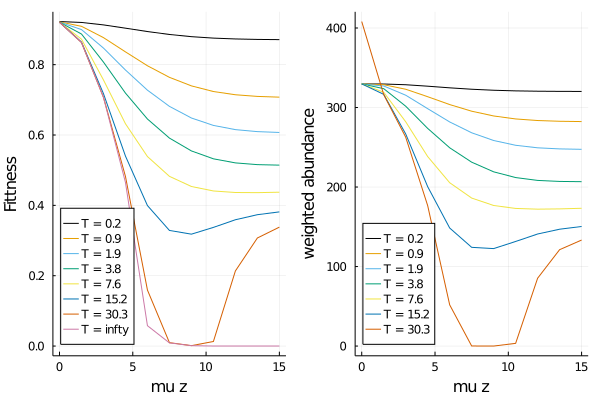

In [81]:
plot(p1,p2, layout = (1,2))

# Switch timing of selection and imigration 

In [50]:

function equilibrium(population, immigrants, s, prop_im, μ_im)
    AgeTraitStructuredModels.reset!(population,0.2)
    Rstar = AgeStructuredModels.compute_Rstar(population.ageStructure)
    AgeTraitStructuredModels.reset_immigrants!(immigrants,population, prop_im*Rstar, μ_im)
    W0 = 10
    W1 = AgeTraitStructuredModels.spawning_stock(population)
    iter = 0
    while abs(W0 - W1) > 10^-5.0
        iter += 1
        W0 = W1
        AgeTraitStructuredModels.time_step_DIS!(population, immigrants)
        W1 = AgeTraitStructuredModels.spawning_stock(population)
    end 

    μrec, σrec = AgeTraitStructuredModels.trait_moments_recruits(population)
    μSSB, σSSB = AgeTraitStructuredModels.trait_moments_spawning(population)
    W = AgeTraitStructuredModels.fittness(population)
    SSB = AgeTraitStructuredModels.spawning_stock(population)
    rec = AgeTraitStructuredModels.recruitment(population)
    
    return W, SSB, rec, μrec, σrec, μSSB, σSSB
end 


function min_outcomes(population, immigrants, T, s, prop_im, μ_im)
    AgeTraitStructuredModels.reset!(population,0.2)
    Rstar = AgeStructuredModels.compute_Rstar(population.ageStructure)
    AgeTraitStructuredModels.reset_immigrants!(immigrants,population, prop_im*Rstar, μ_im)
    W0 = 10
    F0 = 10
    W1 = AgeTraitStructuredModels.spawning_stock(population)
    F1 = AgeTraitStructuredModels.fittness(population)
    iter = 0
    Fmin = -1
    flip = true
    while (W0 > W1) | flip
        iter += 1
        W0 = W1
        F0 = F1
        if iter < T
            AgeTraitStructuredModels.time_step_DIS!(population, immigrants)
        else
            AgeTraitStructuredModels.time_step_DIS!(population)
        end
        W1 = AgeTraitStructuredModels.spawning_stock(population)
        F1 = AgeTraitStructuredModels.fittness(population)
        if (F0 < F1) & (Fmin == -1)
            Fmin = F1
        end 
        
        if flip & (W0 > W1)
            flip = false
        end 
        
    end 
   
    return Fmin, W1
end 

min_outcomes (generic function with 1 method)

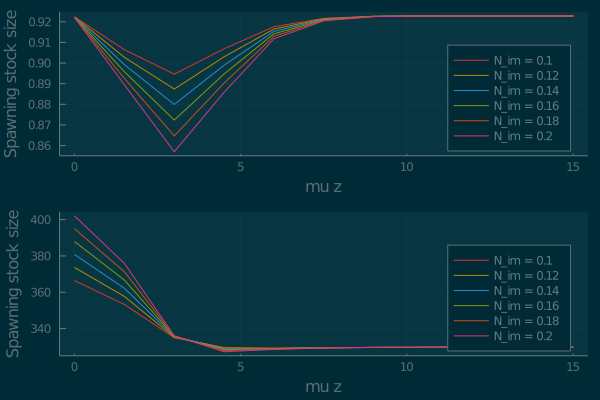

In [51]:

μim = 0.0:1.5:15
s, prop_im = 0.05, 0.1
#equilibrium(pop, im, s, prop_im, 5)
W = broadcast(x -> equilibrium(pop, im, s, prop_im, x)[1:2], μim )
p1 = Plots.plot(μim, broadcast(i -> W[i][1], 1:length(μim )),label = string("N_im = ", prop_im),
                legend =:bottomright, xlab = "mu z", ylab = "Spawning stock size")
p2 = Plots.plot(μim, broadcast(i -> W[i][2], 1:length(μim )),label = string("N_im = ", prop_im),
                legend =:bottomright, xlab = "mu z", ylab = "Spawning stock size")
for prop_im in 0.12:0.02:0.2
    W = broadcast(x -> equilibrium(pop, im, s, prop_im, x)[1:2], μim )
    Plots.plot!(p1,μim, broadcast(i -> W[i][1], 1:length(μim )),label = string("N_im = ", prop_im))
    Plots.plot!(p2,μim, broadcast(i -> W[i][2], 1:length(μim )),label = string("N_im = ", prop_im))
end 
plot(p1,p2, layout = (2,1))

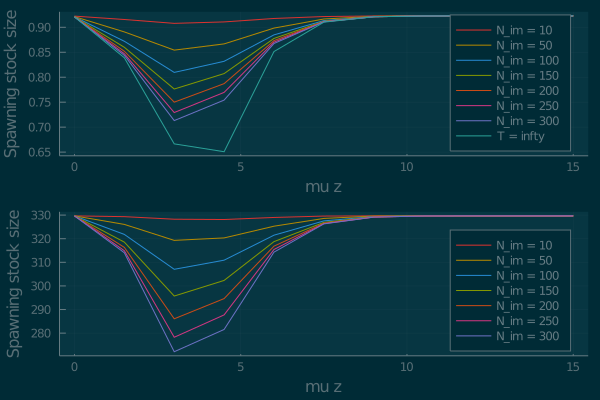

In [52]:
include("AgeTraitStructuredModels.jl")
μim = 0.0:1.5:15
s, prop_im = 0.05, 1.0
T = 10
#equilibrium(pop, im, s, prop_im, 5)
W = broadcast(x -> min_outcomes(pop, im, T, s, prop_im, x)[1:2], μim )
p1 = Plots.plot(μim, W)
p1 = Plots.plot(μim, broadcast(i -> W[i][1], 1:length(μim )),label = string("N_im = ", T),
                legend =:bottomright, xlab = "mu z", ylab = "Spawning stock size")
p2 = Plots.plot(μim, broadcast(i -> W[i][2], 1:length(μim )),label = string("N_im = ", T),
                legend =:bottomright, xlab = "mu z", ylab = "Spawning stock size")
for T in 50:50:300
    W = broadcast(x -> min_outcomes(pop, im, T, s, prop_im, x)[1:2], μim )
    Plots.plot!(p1,μim, broadcast(i -> W[i][1], 1:length(μim )),label = string("N_im = ", T))
    Plots.plot!(p2,μim, broadcast(i -> W[i][2], 1:length(μim )),label = string("N_im = ", T))
end 

W = broadcast(x -> equilibrium(pop, im, s, prop_im, x)[1], μim )

Plots.plot!(p1,μim, broadcast(i -> W[i][1], 1:length(μim )),label = string("T = infty") )

plot(p1,p2, layout = (2,1))

"a1b1c1 "